# MLHB Workshop 3 - Funnel and Bias 🦝 

## 1.1 Types of feedback (or: "the funnel")

In this exercise, we will simulate and analyze a hypothetical recommender system. For simplicty, our system will have a single user, and the goal of the system is to provide her with relevant content.
The user is described by a (latent) vector $u\in \mathbb{R}^d$, which is unknown to the system. For a given item $i$ with features $x_i \in \mathbb{R}^d$ (which are known to the system), relevance to the user is an integer $y \in \{1,\dots,5\}$, given by the following formula:
$$
y=\texttt{round}(\sigma(u^\top x_i)-0.5) \quad \text{where} \quad
\sigma(a)=1+\frac{4}{1+e^{-1.5a}}
$$
Don't be allarmed - the formula simply: computes an inner product, squashes into $[0,1]$, expands to $[1,5]$, and rounds.

To make its recommendations, **the system is given access to two types of data**, generated by the user as a response to past recommendations: clicks, and (possibly) ratings. Specifically, given a training set of previously-recommended items, for each of these items, the system also observes:
  1. A binary *click* label $c \in \{0,1\}$. The user clicks on a recommended item only if its *perceived* relevance $\tilde{y}$ is higher than some threshold `thresh_click`. Perceived relevance differs from true relevance in two ways:
    1. They are based only on partial information (think of how search results include only a short summary of an item). In our case, the user only gets to observe some of the features.
    2. They include additive noise `eps_click` (this is applied to the inner prodect $u^\top x_i$).
  2. An integer *rating* label $r \in \{1,\dots,5\}$. Ratings are based on items relevancies, and are reported *only after items have been consumed*. This means that:
    1. They are based on the entire feature vector (i.e., consuming an items means the user is exposed to the entire feature vector).
    2. They are also affected by additive noise `eps_rating`.
    3. Importantly, they are observed **only for items that have been clicked**.

None of the parameters `thresh_click`, `eps_click`, and `eps_rating` are known to the system.

In this exercise we will explore how the interaction between these two types of user feedback affect learning and recommendation.

### Imports

In [2]:
import pandas as pd
import numpy as np
import uuid
from typing import List, Tuple

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score, mean_squared_error


### The `DatasetGenerator` class

All the datasets in this exercise are represented using `pandas.DataFrame` objects ([API reference](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)).

To generate the synthetic datasets, we will use the `DatasetGenerator` class defined below. The constructor includes three arguments: `thresh_click`, `eps_click`, and `eps_rating`, as described above. Calling `DatasetGenerator()` results in default arguments.

Additionally, the class has two public instance methods that we're going to use:

* `generate_evaluation_set(n_samples)` - Generate evaluation set of the given size. This function returns a `pandas.DataFrame` object. The dataframe is indexed by `item_id`, which is an arbitrary random string assigned to each item. The dataframe has clumns for each of the $d$ features, and and additional `true_relevance` column that stores the true (un-noised) relevancies of all items.

* `generate_training_set(n_samples)` - Generate a training set of the given size. Similarly, this function returns a `pandas.DataFrame` object with the same type of index, and with feature columns. The dataframe does not include ture relevancies; instead it includes two additional columns:
 * The column `click` is an indicator of whether the user clicked an item ($c_{i}\in\{0,1\}$ as in the definitions above).
 * The column `rating` contains the item rating ($r_{i}\in\{1,\dots,5\}$ in the definitions above).

The next cell loads the `DatasetGenerator` class def - please simply run the cell, and ignore the internal implementation. In the cells that follow, we will guide you in how to use its public interface.


### Class definition (hidden)
  
Please ignore internal implementation.

In [3]:
#@title DatasetGenerator Class


class DatasetGenerator(object):
  FEATURE_COLUMNS = [f'x{i+1}' for i in range(8)]

  def __init__(self, thresh_click=2, eps_click=0.4, eps_rating=1):
    self.thresh_click = thresh_click
    self.eps_click = eps_click
    self.eps_rating = eps_rating
    self._latent_dim = len(self.FEATURE_COLUMNS)
    self.top_k_idxs = np.arange(self._latent_dim)<5
    
    self._user_features = np.abs(np.random.randn(self._latent_dim))
    self._user_features /= np.linalg.norm(self._user_features)
    self._user_features_topk = self._user_features*self.top_k_idxs

  def _generate_dataframe(self, n_samples) -> pd.DataFrame:
    return pd.DataFrame(
        index=pd.Index(
            data=[str(uuid.uuid4()) for _ in range(n_samples)],
            name='item_id',
        ),
        data={
            feature_name: np.random.randn(n_samples)
            for feature_name in self.FEATURE_COLUMNS
        }
    )
  
  @staticmethod
  def _click_transform(x):
    return x>2

  @staticmethod
  def _rating_transform(x):
    sigmoid = lambda x: 1/(1+np.exp(-x))
    return np.round((sigmoid(x*1.5)-0.5)*4 + 3).astype(int)

  def generate_evaluation_set(self, n_samples: int) -> pd.DataFrame:
    df = self._generate_dataframe(n_samples)
    X = df[self.FEATURE_COLUMNS].to_numpy()
    scores = X@self._user_features
    y = self._rating_transform(scores)
    return df.assign(true_relevance=y)

  def generate_training_set(self, n_samples: int):
    df = self._generate_dataframe(n_samples)
    X = df[self.FEATURE_COLUMNS].to_numpy()
    for _ in range(1000):  # rejection sampling
      noisy_scores = X@self._user_features_topk + self.eps_click*np.random.logistic(size=X.shape[0])
      y_click = pd.array(
          (noisy_scores > self.thresh_click),
          dtype=pd.Int64Dtype()
      )
      if len(y_click.unique())>1 and y_click.value_counts().min()>1:
        break
    for _ in range(1000):  # rejection sampling
      noisy_scores = X@self._user_features + self.eps_rating*np.random.logistic(size=X.shape[0])
      y_rating = pd.array(
          self._rating_transform(noisy_scores),
          dtype=pd.Int64Dtype(),
      )
      y_rating[y_click==0] = None
      if len(y_rating.dropna().unique())>1:
        break

    return df.assign(click=y_click, rating=y_rating)

### Exploratory analysis

`data_generator` is an instance of the `DatasetGenerator` class:


In [4]:
data_generator = DatasetGenerator()



Here we use the `generate_evaluation_set` function to generate an evaluation set with 500 samples, plot the first 5 rows, and plot an histogram of true (un-noised) relevance scores:

In [28]:
exploratory_evaluation_df = data_generator.generate_evaluation_set(500)
exploratory_evaluation_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,true_relevance
item_id,,,,,,,,,
ce959b09-69f1-4775-8cda-55f219504b73,0.736980,0.035367,-0.034868,0.349759,-0.794358,-0.500148,0.458246,0.476754,3
647a9b80-af75-4ebf-a0ec-cadd911dd1e7,0.214225,-1.196794,0.450071,1.080878,-1.124354,1.168406,-1.020840,1.033228,4
cbb15e66-7f77-4b46-9d30-c93047b96492,0.160938,-0.351979,0.317269,1.211613,-0.067385,-0.210412,-1.020802,-0.765658,2
9cfe0eea-2c9d-4406-b2a1-eba3cbe3aa49,-0.321295,1.351375,0.691259,0.445561,-0.402472,0.251620,-1.274948,-0.346974,3
72b3c269-715f-43c3-8bdd-342d26d14db6,-1.012837,1.430738,1.667154,-1.811945,-0.088337,-1.062810,-0.924545,0.307237,2


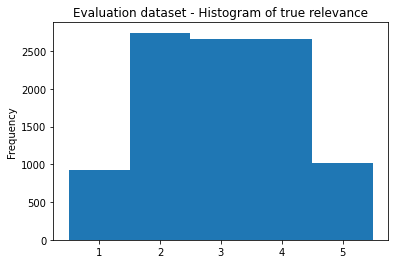

In [29]:
exploratory_evaluation_df['true_relevance'].plot.hist(
    title='Evaluation dataset - Histogram of true relevance',
    bins=[0.5,1.5,2.5,3.5,4.5,5.5]
);

Here we use the `generate_training_set` function to generate a training set of size 10 and print it. Note that values of `rating` are only observed for items that were clicked:

In [30]:
exploratory_training_df = data_generator.generate_training_set(10)
exploratory_training_df

,x1,x2,x3,x4,x5,x6,x7,x8,click,rating
item_id,,,,,,,,,,
9c0ef51e-2902-4071-af82-b68cb598c0b1,-2.264502,-1.044992,0.543058,0.348990,-0.234751,1.010626,-1.065185,1.871938,0,<NA>
6494d43d-64ab-4a4f-8c8b-695910b14d52,-0.368415,-1.017136,-2.329432,-0.588182,0.716261,-1.501895,1.057845,-0.491706,0,<NA>
9fbe0782-372b-4987-aa1a-702ed13948cf,-0.583276,0.134422,0.186190,-1.262705,-1.349169,-1.050803,-0.739928,-0.161992,0,<NA>
1a142c39-042c-4922-a835-c003aa2a61ae,0.582689,-0.601647,0.153887,-0.574792,0.097351,-0.576980,-0.120155,0.030491,0,<NA>
41419482-c56c-4256-8a8e-1398405de293,-0.967506,-1.405122,0.774637,0.209006,0.067691,-0.836073,-0.579599,0.159478,0,<NA>
c670a81f-9443-45ba-b832-3a4c10341122,0.652408,2.027413,-0.208332,-2.486240,-2.445732,0.160843,-0.747796,-0.212992,0,<NA>
6ec8b546-c742-4e54-8043-2bb5e586f7ee,-0.546826,-0.375243,-1.505772,-0.863615,-1.093789,0.433169,0.874777,-1.146319,0,<NA>
78c0df15-ad54-43fd-974f-a51163140e73,0.230508,0.163114,0.029050,1.199585,0.702600,2.023370,-1.100737,0.392704,1,5
52672088-bbd3-40b7-8e6d-e9ee012af5e5,-0.277859,-1.591956,-0.023208,-0.710735,-0.972672,1.033816,1.491507,-0.778016,0,<NA>


### 1.1.1 Exercise: Warm up

To ensure that the technical API is clear, we will start with a couple of technical exercises. 

### 1.1.2 Exploratory analysis
Use `data_generator` to generate a training set of size 1000, and print the first 3 rows:


In [31]:
exploratory_training_df = data_generator.generate_training_set(1000)
exploratory_training_df.head(3)

,x1,x2,x3,x4,x5,x6,x7,x8,click,rating
item_id,,,,,,,,,,
aadc3656-df42-4154-80d0-a591a573593e,-1.332374,0.703172,-0.938696,-0.318348,-0.623386,-1.597595,-0.204574,0.437351,0,<NA>
22296c21-87c2-410a-bef4-8a49fb368af2,0.767308,0.744932,-0.418141,-0.537963,0.935831,0.176469,0.395326,-0.892196,0,<NA>
2786bd7d-4f82-4ed7-8398-2339f50d033d,0.995300,-0.422968,0.273287,-0.328430,0.540526,0.785748,-1.033185,-1.034292,0,<NA>



Calculate the proportion of items that were clicked (result should be a number between 0 and 1):

*(try to do this in one line of pandas code!)*



In [32]:
ratio = (exploratory_training_df["click"] == 1).sum() / (len(exploratory_training_df["click"]))
ratio

0.03

Plot a bar chart showing the number of times each rating value (1,2,...,5) was observed.

*(try to do this in one line of pandas code!)*

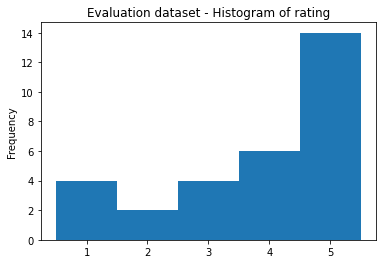

In [33]:
exploratory_training_df['rating'].dropna().plot.hist(
    title='Evaluation dataset - Histogram of rating',
    bins=[0.5,1.5,2.5,3.5,4.5,5.5]
);

Why is this histofram different than the one plotted for the evaluataion set? Explain your answer.

**Answer:** The distribution of the evaluation set is across all data samples, and here we see only the distribution of clicked items. In fact there is high correlation between clicked items and rating them highly. # TODO @manor

### 1.1.3 Basic model training

We define a utility function `build_X_y_matrices` which will also be used later. The function takes an input a dataframe amd a column name for labels (and optionally column names for features), and returns a matrix $X$ with rows including item features, and a vector $y$ of corresponding labels. For label column names, use `click` or `rating` for train data, and `true_relevance` for evaluation data. For ratings data, the function automatically drops any `NaN` entries.

In [34]:
def build_X_y_matrices(
    df: pd.DataFrame,
    label_column: str,
    feature_columns: List[str]=DatasetGenerator.FEATURE_COLUMNS,
    get_valid_entries:bool=False ) -> Tuple[np.ndarray, np.array]:
  """
  Extract training matrices and labels from the dataset DataFrame.
  Entries for which the labels are missing are removed from the dataset.
  Arguments:
  - label_column (str): Name of column to be used as label (e.g 'click')
  - feature_columns (List[str]): Columns to be used as features
  """
  valid_entries = pd.notna(df[label_column])
  X = df.loc[valid_entries][feature_columns].to_numpy()
  y = df.loc[valid_entries][label_column].to_numpy()

  if get_valid_entries:
    return X,y,valid_entries
  else:
    return X,y

Use the above function to:
* Create a train set of size 500 that includes ratings as labels.
* Train a linear regression model (use scikit-learn).
* Create an evaluation set of size 500 (that includes true relevancies $y$).
* Use the learned model to generate predicted relevanceis $\hat{y}$
* Create a violin plot comparing $\hat{y}$ to $\hat{y}$ (code provided).

In [37]:
from sklearn.linear_model import LinearRegression


exploratory_training_df = data_generator.generate_training_set(10000)
x_train, y_train = build_X_y_matrices(exploratory_training_df, label_column="rating")

exploratory_evaluation_df = data_generator.generate_evaluation_set(10000)
x_test, eval_r = build_X_y_matrices(exploratory_evaluation_df, label_column="true_relevance")

pred_r = LinearRegression().fit(x_train, y_train).predict(x_test)

array([2.37321599, 4.32190512, 2.0697422 , ..., 2.13554665, 4.27756996,
       3.35744516])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


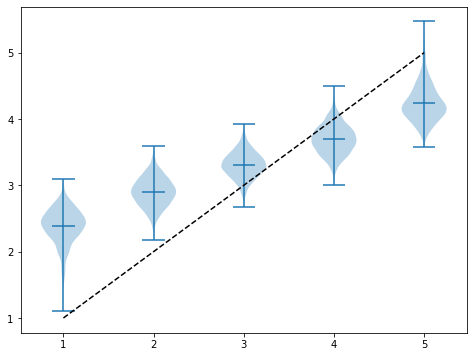

In [36]:
# [plot correlations]

# eval_r: true ratings
# pred_r: predicted ratings

plt.figure(figsize=(8,6))
rs = np.sort(np.unique(eval_r))
pred_per_r = [pred_r[np.where(eval_r==r)] for r in rs]
plt.violinplot(pred_per_r, rs, showmeans=True)
plt.plot([1,5],[1,5],'k--');
plt.show()

**Explain the plot -** Does the linear regression model capture the true relevance? 

Answer: The black linear line indicate the correct predictions. We see that the linear regression tends to predict close to the average all of possible rating (3), so it oversstimate items with low `true_relevance` and underestimate items with high `true_relevance`.

### 1.1.4 The effect of dataset size

* Create a `DatasetGenerator` object with default arguments, and use it to generate an evaluation set of size 500.
* For each n in `geomspace(50,20000,8)`, generate a training dataset of size n.
* Train a click-prediction model using logistic regression.
* Train a rating-prediction model using linear regression.
* Evaluate and store the NDCG of each model on the evaluation set (use the following `ndcg_10` fuction that wraps scikit-learn's `ndcg_score` for top 10).
* For each value of n, repeat the above procedure 20 times, and save results in `results_lst`.
* Plot a line-plot showing the average NDCG per n for each of the two models. Include error bars. (The plotting function is given below.)

In [73]:
# Calculates ndcg at 10
# Input: 2 arrays, true and estimated relevance
# Output: float, score

ndcg_10 = lambda y_true, y_est: ndcg_score(
    np.expand_dims(y_true, 0),
    np.expand_dims(y_est, 0),
    k=10,
)

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def for_data_generator(data_generator, num_repeats, thresh_click):
  log_model = LogisticRegression()
  lin_model = LinearRegression()

  exploratory_evaluation_df = data_generator.generate_evaluation_set(500)
  x_test, eval_r = build_X_y_matrices(exploratory_evaluation_df, label_column="true_relevance")

  n_values_lst = np.geomspace(50,20000,8).astype(int)
  results_lst = []

  for rpt in range(num_repeats):
    for n_samples in n_values_lst:

      exploratory_training_df = data_generator.generate_training_set(n_samples)

      x_train, y_train = build_X_y_matrices(exploratory_training_df, label_column="click")
      pred_r_prob_log = log_model.fit(x_train, y_train.astype(float)).predict_proba(x_test)

      x_train, y_train = build_X_y_matrices(exploratory_training_df, label_column="rating")
      pred_r_lin = lin_model.fit(x_train, y_train).predict(x_test)

      # store results:
      results_lst.append({
          'thresh_click': thresh_click,
          'n_samples': n_samples,
          'repetition': rpt,
          'click_ndcg': ndcg_10(eval_r, pred_r_prob_log[:, 1]),
          'rating_ndcg': ndcg_10(eval_r, pred_r_lin),
      })

  results_df = pd.DataFrame(results_lst)
  return results_df

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
num_repeats = 20

data_generator = DatasetGenerator()

results_df = for_data_generator(data_generator, num_repeats, thresh_click=data_generator.thresh_click)
results_df.head()

,thresh_click,n_samples,repetition,click_ndcg,rating_ndcg
0,2,49,0,0.956923,0.755841
1,2,117,0,1.000000,0.756827
2,2,276,0,0.900293,0.487546
3,2,651,0,0.903337,0.451515
4,2,1534,0,0.931580,0.972863


Run the following cell to plot your results:

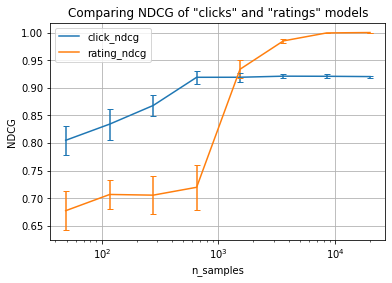

In [76]:
(
  results_df
  .groupby('n_samples')
  .agg(['mean','sem'])
  [['click_ndcg','rating_ndcg']]
  .swaplevel(axis=1)
  .pipe(lambda df: df['mean'].plot.line(
          logx=True,
          yerr=df['sem'],
          capsize=3,
          legend=True,
          grid=True,
          ylabel='NDCG',
          title='Comparing NDCG of "clicks" and "ratings" models'
      )
  )
);


Explain your results.

**Answer:** First, the more samples we have, the lower is the stderr (as expected). Regarding trends - when we have a small number of samples, the rating is biased towards highly-rated examples (since the user rates only samples she chose), while clicks "sees" all examples. In addition, when we have X samples, clicks "see" all of them, while rating "see" a lot less, since she can only access examples there were clicked. When increasing the number of samples, rating gets to see more and more diverse examples, both highly and poorly rated, thus it gets better in predicting the correct ratings while the click predictor saturates and reach its upper bound, since it sees only partial information as opposed to the rating predictor that sees all the information, a fact that doesn't get improved when having more examples.

### 1.1.5 Varying click threshold
Repeat the experiment, but this time:
* Keep the number of samples fixed at 1000.
* Vary the click noise factor $\mathtt{thresh\_click} \in\{0,0.25,\dots,3\}$. Pass this as a parameter to the DatasetGenerator constructor (note this means that now the data generator object should be constructed *inside* the loop).
* For every noise factor run 20 random repeats and average.

(Feel free to reuse code from the above question)

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def for_data_generator(data_generator, num_repeats, thresh_click):
  log_model = LogisticRegression()
  lin_model = LinearRegression()

  exploratory_evaluation_df = data_generator.generate_evaluation_set(500)
  x_test, eval_r = build_X_y_matrices(exploratory_evaluation_df, label_column="true_relevance")

  results_lst = []

  for rpt in range(num_repeats):

    exploratory_training_df = data_generator.generate_training_set(1000)

    x_train, y_train = build_X_y_matrices(exploratory_training_df, label_column="click")
    pred_r_prob_log = log_model.fit(x_train, y_train.astype(float)).predict_proba(x_test)

    x_train, y_train = build_X_y_matrices(exploratory_training_df, label_column="rating")
    pred_r_lin = lin_model.fit(x_train, y_train).predict(x_test)

    # store results:
    results_lst.append({
        'thresh_click': thresh_click,
        'n_samples': 1000,
        'repetition': rpt,
        'click_ndcg': ndcg_10(eval_r, pred_r_prob_log[:, 1]),
        'rating_ndcg': ndcg_10(eval_r, pred_r_lin),
    })

  results_df = pd.DataFrame(results_lst)
  return results_df

In [87]:
from tqdm.notebook import tqdm


num_repeats = 20

results_df = pd.DataFrame()
for thresh_click in tqdm(np.linspace(0, 3, num=13, endpoint=True)):

  np.random.seed(42)
  data_generator = DatasetGenerator(thresh_click=thresh_click)
  df = for_data_generator(data_generator, num_repeats, thresh_click=data_generator.thresh_click)
  results_df = pd.concat([results_df, df])

results_df.head()

  0%|          | 0/13 [00:00<?, ?it/s]

,thresh_click,n_samples,repetition,click_ndcg,rating_ndcg
0,0.0,1000,0,0.903436,1.0
1,0.0,1000,1,0.927144,1.0
2,0.0,1000,2,0.915525,1.0
3,0.0,1000,3,0.914176,1.0
4,0.0,1000,4,0.939232,1.0


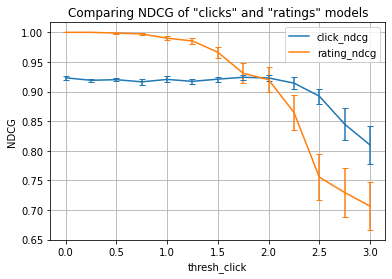

In [88]:
(
  results_df
  .groupby('thresh_click')
  .agg(['mean','sem'])
  [['click_ndcg','rating_ndcg']]
  .swaplevel(axis=1)
  .pipe(lambda df: df['mean'].plot.line(
          yerr=df['sem'],
          capsize=3,
          legend=True,
          grid=True,
          ylabel='NDCG',
          title='Comparing NDCG of "clicks" and "ratings" models'
      )
  )
);


Explain your results.

Answer: TODO

### 1.1.6 Varying click noise
Repeat the experiment, but this time:
* Keep the number of samples fixed at 250.
* Vary the click noise factor $\mathtt{eps\_click} \in\{0.25,0.5,\dots,3.5\}$. Pass this as a parameter to the DatasetGenerator constructor (be sure to use the constructor *inside* the loop).
* For every noise factor run 50 random repeats and average.

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def for_data_generator(data_generator, num_repeats, eps_click):
  log_model = LogisticRegression()
  lin_model = LinearRegression()

  exploratory_evaluation_df = data_generator.generate_evaluation_set(500)
  x_test, eval_r = build_X_y_matrices(exploratory_evaluation_df, label_column="true_relevance")

  results_lst = []

  for rpt in range(num_repeats):

    exploratory_training_df = data_generator.generate_training_set(1000)

    x_train, y_train = build_X_y_matrices(exploratory_training_df, label_column="click")
    pred_r_prob_log = log_model.fit(x_train, y_train.astype(float)).predict_proba(x_test)

    x_train, y_train = build_X_y_matrices(exploratory_training_df, label_column="rating")
    pred_r_lin = lin_model.fit(x_train, y_train).predict(x_test)

    # store results:
    results_lst.append({
        'eps_click': eps_click,
        'n_samples': 1000,
        'repetition': rpt,
        'click_ndcg': ndcg_10(eval_r, pred_r_prob_log[:, 1]),
        'rating_ndcg': ndcg_10(eval_r, pred_r_lin),
    })

  results_df = pd.DataFrame(results_lst)
  return results_df

In [90]:
from tqdm.notebook import tqdm


num_repeats = 20

results_df = pd.DataFrame()
for eps_click in tqdm(np.linspace(0.25, 3.5, num=14, endpoint=True)):

  np.random.seed(42)
  data_generator = DatasetGenerator(eps_click=eps_click)
  df = for_data_generator(data_generator, num_repeats, eps_click=data_generator.eps_click)
  results_df = pd.concat([results_df, df])

results_df.head()

  0%|          | 0/14 [00:00<?, ?it/s]

,eps_click,n_samples,repetition,click_ndcg,rating_ndcg
0,0.25,1000,0,0.869280,0.987276
1,0.25,1000,1,0.919235,0.977991
2,0.25,1000,2,0.942475,0.723425
3,0.25,1000,3,0.826223,0.764071
4,0.25,1000,4,0.972076,0.382140


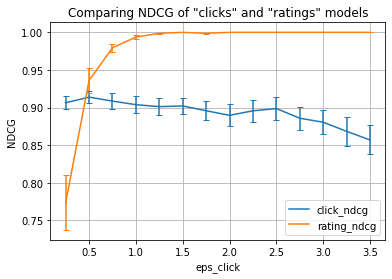

In [91]:
(
  results_df
  .groupby('eps_click')
  .agg(['mean','sem'])
  [['click_ndcg','rating_ndcg']]
  .swaplevel(axis=1)
  .pipe(lambda df: df['mean'].plot.line(
          yerr=df['sem'],
          capsize=3,
          legend=True,
          grid=True,
          ylabel='NDCG',
          title='Comparing NDCG of "clicks" and "ratings" models'
      )
  )
);

Are these results surprising? Explain.

**Answer:** TODO

## 1.2 Biased ratings

In real life, users rarely rate all items they consume. Moreover - both the choice of *which* items to rate, and the actual *reported* ratings, are prone to behavioral biases. In this question we will examine the effects of different reporting schemes (i.e., ways in which uesrs report or fail to report ratings, and how they modify these ratings) on learning.


We will examine five types of users:
- Rational (random): Each rating $r$ is reported with a fixed probability $p=0.4$. Note this serves as a benchmark since it does not add bias to how ratings are reported.
- Ranting: Only reports bad ratings, defined as $r \le 2$.
- Extereme: Only reports extreme ratings, defined as $r=1$ or $r=5$.
- Optimistic: Reports only if ratings are high, $r \ge 4$, but for each item with true relevance $r=4$, misreports it as $r=5$ with probability $p=0.8$.
- Overreacts: Reports ratings for items with low ratings $r \le 2$ and with high ratings $r \ge 4$, and for these, reports them with probability $p=0.5$. However, he extremifies his ratings by misreporting $r=2$ as $r=1$ and $r=4$ as $r=5$.
- **[Bonus]** *Joker: implement your own type!*

Note: the above criterions and probabilities ensure that for all types, 40% of ratings are reported, so all types generate the same (expected) number of ratings. If you implement a Joker, ensure this holds as well.



### 1.2.1 Implementing user types
Implement a function `selective_ratings` that takes as input an array `r_arr` of ratings, and simulates user behavior by returning a subset of `r_arr` matching one of the above types of user reporting behaviors, as determined by the parameter `utype`. The function also takes as input the set of item features `items_train`, and returns the subset of items corresponding to the reported ratings.


In [95]:
from scipy.stats import bernoulli


def selective_ratings(r_arr, utype='rational',items_train=None):

  np.random.seed(0)

  """
  input:
  r_arr: ratings array - numpy
  utype: string

  return: numpy array of revealed ratings, the corresponding item features
  """

  n_samples = len(r_arr)

  if utype=='rational':

    mask = (np.random.random_sample(size=(n_samples, )) < 0.4)
    r_arr = r_arr[mask]
    if items_train is not None:
      items_train = items_train[mask, ...]

    return r_arr, items_train

  if utype=='ranting':

    mask = (r_arr <= 2)
    r_arr = r_arr[mask]
    if items_train is not None:
      items_train = items_train[mask, ...]

    return r_arr, items_train

  if utype=='extreme':

    mask = (r_arr == 1) + (r_arr == 5)
    r_arr = r_arr[mask]
    if items_train is not None:
      items_train = items_train[mask, ...]

    return r_arr, items_train

  if utype=='optimistic':

    mask = (r_arr >= 4)  
    r_arr = r_arr[mask]

    optimism_mask = (np.random.random_sample(size=(len(r_arr), )) < 0.8)
    r_arr[optimism_mask] = 5

    if items_train is not None:
      items_train = items_train[mask, ...]

    return r_arr, items_train

  if utype=='overreacts':

    mask = (r_arr <= 2) + (r_arr >= 4)    
    r_arr = r_arr[mask]

    if items_train is not None:
      items_train = items_train[mask, ...]

    overreacts_mask = (np.random.random_sample(size=(len(r_arr), )) < 0.5)
    r_arr = r_arr[overreacts_mask]

    if items_train is not None:
      items_train = items_train[overreacts_mask, ...]

    r_arr[r_arr == 2] = 1
    r_arr[r_arr == 4] = 5

    return r_arr, items_train

  if utype=='polish':

    r_arr = 3 * np.ones_like(r_arr) # TODO

    return r_arr, items_train

Use the next block of code to experiment with your ratings filter models (optional).

In [ ]:
"""

Try you code - optional
You may use ratings generated below of the evaluation..

"""

## 1.2.2 Training and evaluation

In this section we will:
* generates train and test data
* filters rating for each user type based on your implementation of `selective_ratings'
* 

(If you implemented a Joker type - add it to the code below)

**Before actually running the code** - give an educated guess for NDCG and RMSE values for each user type (if values are hard for you to guess, state relations, e.g. 'higher', 'lower', 'much lower'):

In [ ]:
Answer:...

Now, run the following cell, which generates data, trains, evaluates, and prints and stores predictions, NDCG, and RMSE test measures for each type.

In [96]:
np.random.seed(42)
data_generator = DatasetGenerator()

# generate train data
train_df = data_generator.generate_training_set(5000)
items_train, ratings_train = build_X_y_matrices(train_df, 'rating')

# generate test data
test_df = data_generator.generate_evaluation_set(1000)
items_test, true_relevance = build_X_y_matrices(test_df, 'true_relevance')

utypes = ['rational', 'ranting', 'extreme', 'optimistic', 'overreacts', 'polish']

ndcgs = []
rmses = []
preds = []
for utype in utypes:
  # train
  ratings_train_, items_train_ = selective_ratings(ratings_train, utype,items_train)
  clf2 = LinearRegression().fit(items_train_, ratings_train_)

  # predict, evaluate, and store results
  pred_test = clf2.predict(items_test)
  preds.append(pred_test)
  ndcgs.append(ndcg_10(true_relevance, pred_test))
  rmses.append(np.sqrt(mean_squared_error(true_relevance, pred_test)))

  # print results
  print(utype)
  print('ndcg:', ndcgs[-1])
  print('rmse:', rmses[-1])
  print()

rational
ndcg: 0.985327215580128
rmse: 0.9263708841364119

ranting
ndcg: 0.6187629318641255
rmse: 1.6244550720118534

extreme
ndcg: 0.9872758423602097
rmse: 1.4258220725225021

optimistic
ndcg: 0.6739632583268074
rmse: 2.222138253621638

overreacts
ndcg: 0.676606385875945
rmse: 2.2128142824217814

joker
ndcg: 0.6038
rmse: 1.1708970919769166



### 1.2.3 Comparing guesses and results
Do these results match your guesses? Why, or why not?

To answer, first run the cell below which generates violin plots for each user type, and use it in your explanation.

In [ ]:
Answer:...

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


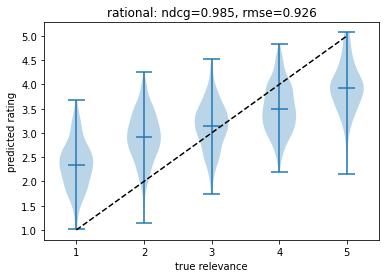

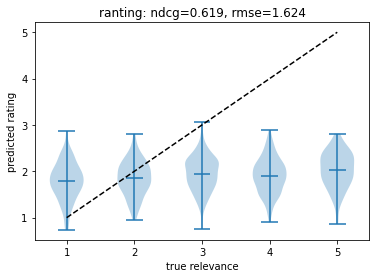

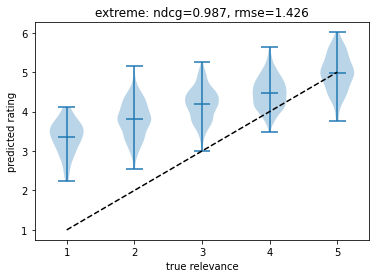

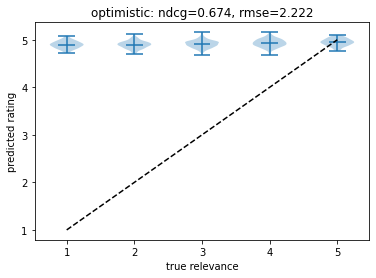

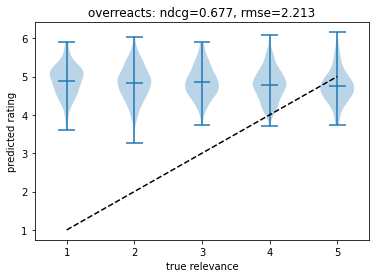

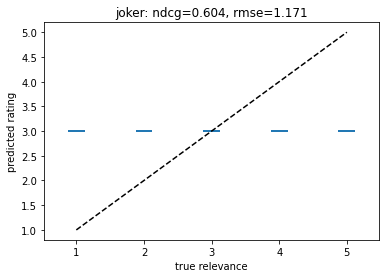

In [97]:
for utype_, pred_, ndcg_, rmse_ in zip(utypes, preds, ndcgs, rmses):
  rs = np.sort(np.unique(true_relevance))
  pred_per_r = [pred_[np.where(true_relevance==r)] for r in rs]
  plt.violinplot(pred_per_r, rs, showmeans=True)
  plt.plot([1,5],[1,5],'k--');
  plt.xlabel('true relevance')
  plt.ylabel('predicted rating')
  plt.title('{}: ndcg={:.3f}, rmse={:.3f}'.format(utype_, ndcg_, rmse_))
  plt.show()